In [1]:
# ----------------------------------------
# 0. Setup
# ----------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, confusion_matrix, classification_report
import warnings

In [2]:
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)

# RMSLE Function
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

# Cross-Validation RMSLE
def cv_rmsle(model, X, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = np.sqrt(-cross_val_score(model, X, np.log1p(y), scoring="neg_mean_squared_error", cv=kf))
    return rmse_scores

Training data shape: (1460, 80)


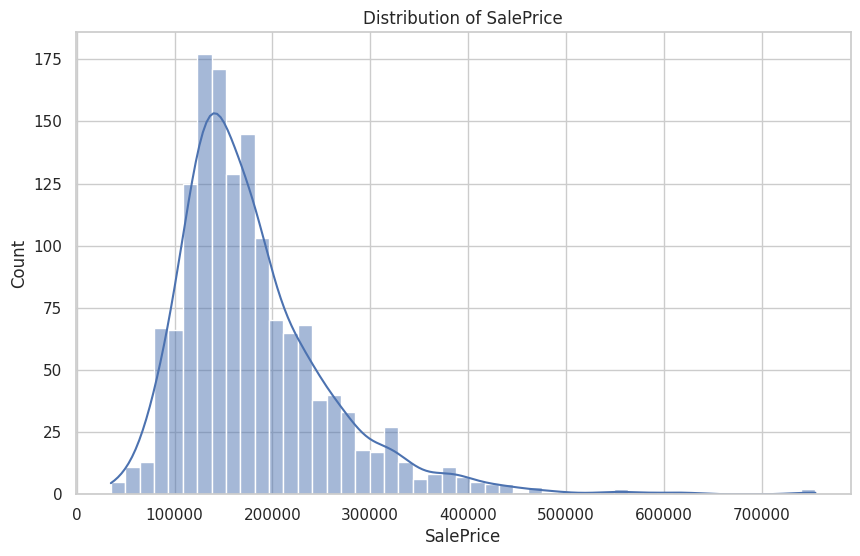

Skewness of SalePrice: 1.88


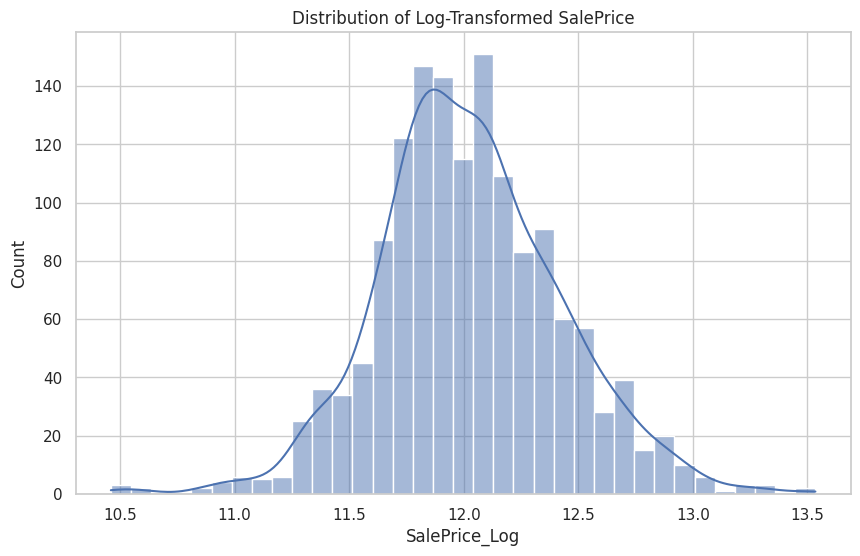

Skewness of Log-Transformed SalePrice: 0.12


In [3]:
# ----------------------------------------
# 1. Load and Explore Data (EDA)
# ----------------------------------------

try:
    df_train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
except FileNotFoundError:
    df_train = pd.read_csv('train.csv')

# Drop ID column
train_ids = df_train['Id']
df_train.drop('Id', axis=1, inplace=True)

print(f"Training data shape: {df_train.shape}")

# Target variable distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_train['SalePrice'], kde=True)
plt.title('Distribution of SalePrice')
plt.show()

print(f"Skewness of SalePrice: {df_train['SalePrice'].skew():.2f}")

# Log transform SalePrice
df_train['SalePrice_Log'] = np.log1p(df_train['SalePrice'])

plt.figure(figsize=(10, 6))
sns.histplot(df_train['SalePrice_Log'], kde=True)
plt.title('Distribution of Log-Transformed SalePrice')
plt.show()

print(f"Skewness of Log-Transformed SalePrice: {df_train['SalePrice_Log'].skew():.2f}")

In [4]:
# ----------------------------------------
# 2. Handle Missing Values
# ----------------------------------------

# Find missing values
missing = df_train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("\nMissing Data:")
print(missing)

# Fill missing values
cat_na_means_none = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                     'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
                     'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
num_na_means_zero = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
                     'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']
cat_na_impute_mode = ['Electrical', 'MasVnrType', 'MSZoning', 'Functional',
                      'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'SaleType']
num_na_impute_median = ['LotFrontage']

for col in cat_na_means_none:
    if col in df_train.columns:
        df_train[col] = df_train[col].fillna('None')

for col in num_na_means_zero:
    if col in df_train.columns:
        df_train[col] = df_train[col].fillna(0)

for col in cat_na_impute_mode:
    if col in df_train.columns:
        df_train[col] = df_train[col].fillna(df_train[col].mode()[0])

for col in num_na_impute_median:
    if col in df_train.columns:
        df_train[col] = df_train[col].fillna(df_train[col].median())

print(f"\nRemaining missing values: {df_train.isnull().sum().sum()}")


Missing Data:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

Remaining missing values: 0


In [5]:
# ----------------------------------------
# 3. Preprocessing (Log Transform Skewed Features)
# ----------------------------------------

X = df_train.drop(['SalePrice', 'SalePrice_Log'], axis=1)
y = df_train['SalePrice_Log']

numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

skewed_feats = X[numerical_cols].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[abs(skewed_feats) > 0.75].index

for feat in skewed_feats:
    X[feat] = np.log1p(X[feat])


In [6]:
# ----------------------------------------
# 4. Encoding and Scaling
# ----------------------------------------

ordinal_features_map = {
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Fa', 'TA', 'Gd', 'Ex'],
    'PavedDrive': ['N', 'P', 'Y']
}
ordinal_cols = list(ordinal_features_map.keys())
nominal_cols = [col for col in categorical_cols if col not in ordinal_cols]

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=[ordinal_features_map[col] for col in ordinal_cols], handle_unknown='use_encoded_value', unknown_value=-1))
])

nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('nom', nominal_transformer, nominal_cols)
    ])

In [7]:
# ----------------------------------------
# 5. Train Models
# ----------------------------------------

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

models = {
    "Ridge Regression": Ridge(alpha=10, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, max_depth=15, min_samples_split=5, min_samples_leaf=3),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_val_processed)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)

    results[name] = {
        "RMSE_log": rmse,
        "R2_log": r2,
        "MAE_log": mae
    }

# Show results
comparison_df = pd.DataFrame(results).T
print("\n--- Model Comparison ---")
print(comparison_df.sort_values(by='RMSE_log'))


--- Model Comparison ---
                   RMSE_log    R2_log   MAE_log
Ridge Regression   0.129589  0.910009  0.087798
Gradient Boosting  0.134462  0.903114  0.091622
Random Forest      0.146549  0.884913  0.098578


In [8]:
# ----------------------------------------
# 6. Descriptive Statistics
# ----------------------------------------

grlivarea_mean = df_train['GrLivArea'].mean()
grlivarea_std = df_train['GrLivArea'].std()

print("\n--- Descriptive Statistics for 'GrLivArea' ---")
print(f"Mean: {grlivarea_mean:.2f}")
print(f"Standard Deviation: {grlivarea_std:.2f}")


--- Descriptive Statistics for 'GrLivArea' ---
Mean: 1515.46
Standard Deviation: 525.48


In [9]:
# ----------------------------------------
# 7. Regression (Simple Linear Regression)
# ----------------------------------------

X_simple_reg = df_train[['GrLivArea', 'TotalBsmtSF']]
y_simple_reg = df_train['SalePrice_Log']

X_train_simple, X_val_simple, y_train_simple, y_val_simple = train_test_split(X_simple_reg, y_simple_reg, test_size=0.2, random_state=42)

lin_reg = LinearRegression()
lin_reg.fit(X_train_simple, y_train_simple)
y_pred_simple = lin_reg.predict(X_val_simple)

rmse_simple = np.sqrt(mean_squared_error(y_val_simple, y_pred_simple))
r2_simple = r2_score(y_val_simple, y_pred_simple)

print("\n--- Simple Linear Regression ---")
print(f"Validation RMSE: {rmse_simple:.5f}")
print(f"Validation R²: {r2_simple:.5f}")


--- Simple Linear Regression ---
Validation RMSE: 0.24989
Validation R²: 0.66538


In [10]:
# ----------------------------------------
# 8. Classification (Logistic Regression)
# ----------------------------------------

threshold = df_train['SalePrice_Log'].median()
df_train['Expensive'] = (df_train['SalePrice_Log'] > threshold).astype(int)

X_class = df_train[['GrLivArea', 'TotalBsmtSF']]
y_class = df_train['Expensive']

X_train_class, X_val_class, y_train_class, y_val_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

log_reg = LogisticRegression()
log_reg.fit(X_train_class, y_train_class)

y_pred_class = log_reg.predict(X_val_class)

accuracy = accuracy_score(y_val_class, y_pred_class)
conf_matrix = confusion_matrix(y_val_class, y_pred_class)
class_report = classification_report(y_val_class, y_pred_class)

print("\n--- Logistic Regression Classification ---")
print(f"Accuracy: {accuracy:.5f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


--- Logistic Regression Classification ---
Accuracy: 0.84932

Confusion Matrix:
 [[139  22]
 [ 22 109]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86       161
           1       0.83      0.83      0.83       131

    accuracy                           0.85       292
   macro avg       0.85      0.85      0.85       292
weighted avg       0.85      0.85      0.85       292

